# Summarization Multinews
In this project, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on Multinews datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base`

**Datasets:**
- Multi-News – news articles and human-written summaries of these articles

In [ ]:

from datasets import load_dataset , load_from_disk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from tqdm import tqdm 

from transformers import BartTokenizer

/Users/shubby/Desktop/UB/Sem2/DeepLearning/ass2/a2env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Dataset preparation and preprocessing

1. Select and load one dataset from the list above. You can download these datasets using the `datasets` package.

In [ ]:
dataset = load_dataset("multi_news" , trust_remote_code=True)

In [ ]:
train = dataset["train"]
test = dataset["test"]
val = dataset["validation"]

In [ ]:
print("Document: ", train[0]["document"])
print("\n\n")
print("Summary: ", train[0]["summary"])

Document:  National Archives 
 
 Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. 
 
 A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. 
 
 Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
 
 Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. economy may not be 

2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [ ]:
print("train size: ", len(train))
print("test size: ", len(test))
print("validation size: ", len(val))

train size:  44972
test size:  5622
validation size:  5622


Average summary length:  1300.3036333718758
Average document length:  11017.722071511162


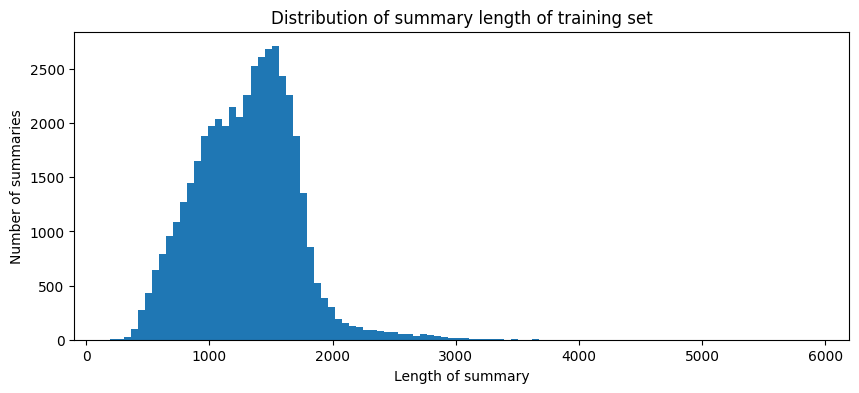

In [ ]:
#average length of the documents and summaries
doc_len = []
sum_len = []
for i in range(len(train)):
    doc_len.append(len(train[i]["document"]))
    sum_len.append(len(train[i]["summary"]))
print("Average summary length: ", np.mean(sum_len))
print("Average document length: ", np.mean(doc_len))


#distribution of the summary length
plt.figure(figsize=(10, 4))
plt.hist(sum_len, bins=100)
plt.title("Distribution of summary length of training set")
plt.xlabel("Length of summary")
plt.ylabel("Number of summaries")
plt.show()


Average summary length:  1293.1641764496621
Average document length:  11067.969939523302


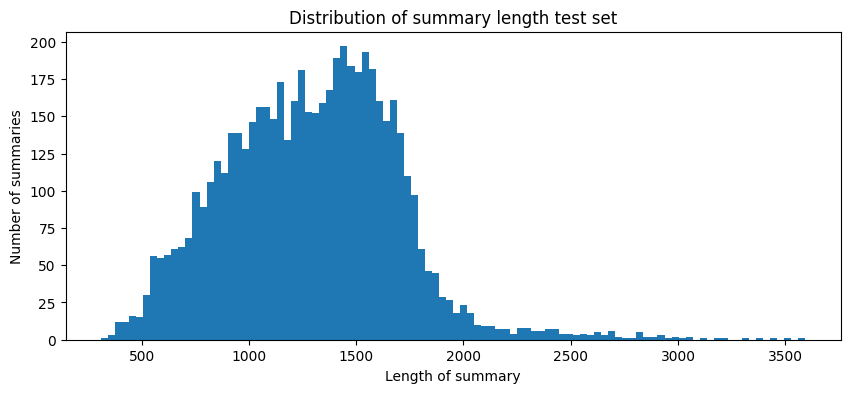

In [ ]:
doc_len = []
sum_len = []
for i in range(len(test)):
    doc_len.append(len(test[i]["document"]))
    sum_len.append(len(test[i]["summary"]))
print("Average summary length: ", np.mean(sum_len))
print("Average document length: ", np.mean(doc_len))


#distribution of the summary length
plt.figure(figsize=(10, 4))
plt.hist(sum_len, bins=100)
plt.title("Distribution of summary length test set")
plt.xlabel("Length of summary")
plt.ylabel("Number of summaries")
plt.show()


Average summary length:  1290.6648879402348
Average document length:  10756.317324795447


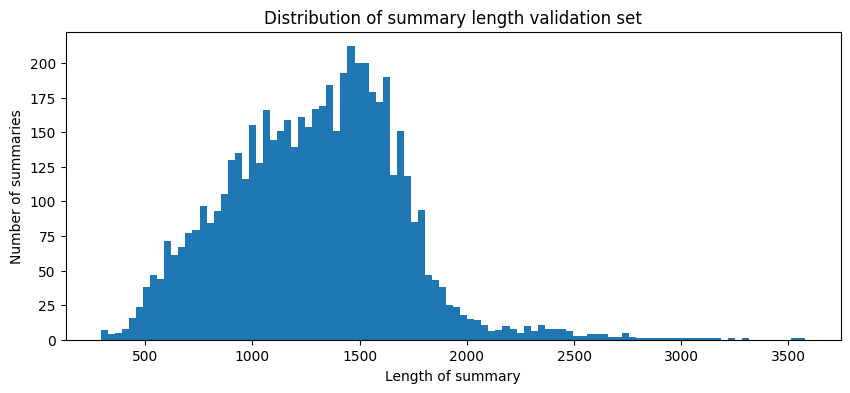

In [ ]:
doc_len = []
sum_len = []
for i in range(len(val)):
    doc_len.append(len(val[i]["document"]))
    sum_len.append(len(val[i]["summary"]))
print("Average summary length: ", np.mean(sum_len))
print("Average document length: ", np.mean(doc_len))


#distribution of the summary length
plt.figure(figsize=(10, 4))
plt.hist(sum_len, bins=100)
plt.title("Distribution of summary length validation set")
plt.xlabel("Length of summary")
plt.ylabel("Number of summaries")
plt.show()


3. Preprocessing:

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [ ]:
# average token length of the documents and summaries
from tqdm import tqdm 

doc_len = []
sum_len = []
for i in tqdm(range(len(train))):
    doc_len.append(len(tokenizer.tokenize(train[i]["document"])))
    sum_len.append(len(tokenizer.tokenize(train[i]["summary"])))
print("Average summary length: ", np.mean(sum_len))
print("Average document length: ", np.mean(doc_len))



100%|██████████| 44972/44972 [03:36<00:00, 207.49it/s]

Average summary length:  278.1814239971538
Average document length:  2540.48981588544


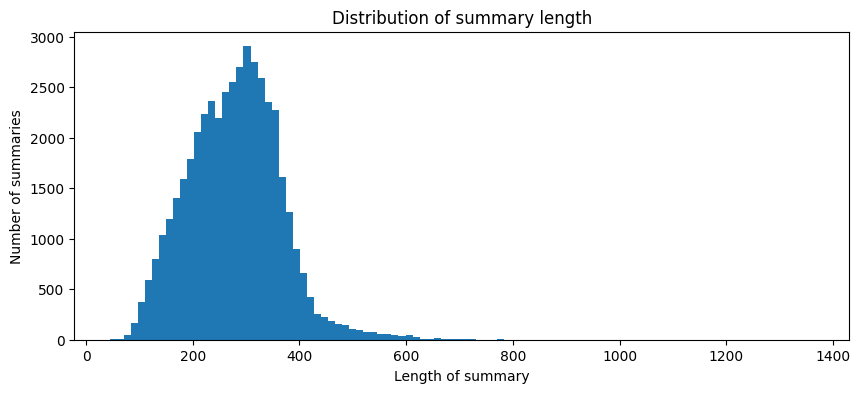

In [ ]:
#distribution of the summary length
plt.figure(figsize=(10, 4))
plt.hist(sum_len, bins=100)
plt.title("Distribution of summary length")
plt.xlabel("Length of summary")
plt.ylabel("Number of summaries")
plt.show()

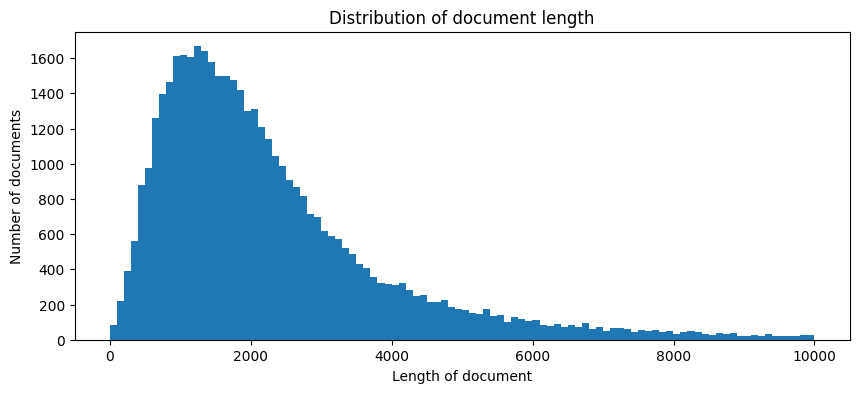

In [ ]:
#distribution of the document length
doc_len = np.array(doc_len)
doc_len_new = doc_len[doc_len < 10000]

plt.figure(figsize=(10, 4))
plt.hist(doc_len_new, bins=100)
plt.title("Distribution of document length")
plt.xlabel("Length of document")
plt.ylabel("Number of documents")
plt.show()

   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

In [ ]:
#setting max input to 1024 and target length to 256

def tokenized_input(data , max_input_length=1024 , max_target_length=256):
    doc = tokenizer(
        data["document"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    with tokenizer.as_target_tokenizer():
        sum = tokenizer(
            data["summary"],
            max_length=max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
    # convert to dict
    return {
        "input_ids": doc["input_ids"],
        "attention_mask": doc["attention_mask"],
        "labels" : sum["input_ids"]
    }
    
 

In [ ]:
dataset = dataset.map(tokenized_input, batched=True , batch_size=1000)

Map: 100%|██████████| 5622/5622 [00:40<00:00, 138.98 examples/s]


4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5622
    })
})

5. Save the tokenized dataset locally to avoid reprocessing.

In [ ]:
## Save the dataset to disk
#dataset.save_to_disk("multi_news_dataset")


# Load the dataset from disk
dataset = load_from_disk("multi_news_dataset")

6. Briefly describe your preprocessing methodology.

<span style='color:green'>Preprocessing of data contains 3 main features </br>
1. Tokenization using Bart tokenizer</br>
2. Padding and Truncation of token sequence till 1024 which is the max limit for bart model</br>
3. Stored data in 3 keys 'input_ids' , 'attention_mask' and 'labels' </span>

## Step 2: Model Fine-Tuning

1. Use the pre-trained model `facebook/bart-base` from Hugging Face.

In [ ]:
import torch
import evaluate

from transformers import DataCollatorForSeq2Seq
from transformers import BartForConditionalGeneration
from transformers import TrainingArguments, Trainer

#For MAC
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

2025-04-10 12:36:14.446860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 12:36:14.649072: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


device(type='cuda')

In [ ]:

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base" , low_cpu_mem_usage=True)

# Move model to the device
model = model.to(device)

2025-04-09 20:22:01.688648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 20:22:01.830184: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

2. Training:

   - Fine-tune the model on the tokenized training set.

In [ ]:

training_args = TrainingArguments(
    output_dir="./bart_results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    warmup_steps=500,
    eval_steps=500,
    save_steps=500,
    gradient_accumulation_steps=8,
    logging_dir="./logs",  
    logging_steps=100,     
    eval_strategy="steps",  
    save_strategy="steps",        
    #load_best_model_at_end=True,  
    fp16=True                    
)

model.generation_config.num_beams = 1


   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [ ]:
class CustomTrainer(Trainer):
    
    def evaluate(self , eval_dataset=None, ignore_keys=None, metric_key_prefix: str = "eval" ):
        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        
        self.model.eval()
        #print("Evaluating...")
        predictions = []
        labels = []
        for batch in tqdm(eval_dataloader):
            
            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    max_length=250,
                    early_stopping=True,
                    labels=batch["labels"],
                )
                # Calculate loss
                output = self.model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"])
            
            total_loss = output.loss.item()
            predictions.extend(generated_ids)
            labels.extend(batch["labels"])
            
        
        
        avg_loss = total_loss / len(eval_dataloader)
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        
        # Calculate Bleu scores  
        bleu_result = self.compute_metrics((decoded_preds, decoded_labels))
        log_data = {"eval_loss": avg_loss , "step" : self.state.global_step , "bleu" : bleu_result["bleu"]}
        
        print(log_data)
        self.log(log_data)
        return avg_loss

In [ ]:


bleu_metric = evaluate.load("bleu" , trust_remote_code=True)

def compute_rogue_metric(eval_preds):
    
    pred , label = eval_preds
    result = bleu_metric.compute(predictions=pred , references=label)["bleu"]
    
    return {"bleu" : result}



In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"].select(range(1000)),
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    compute_metrics=compute_rogue_metric,
)

/scratch/19314200/ipykernel_1020201/1571008658.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
results_logs = trainer.train()

Step,Training Loss,Validation Loss


  0%|          | 0/125 [00:00<?, ?it/s]/user/shubham/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 125/125 [03:27<00:00,  1.66s/it]


{'eval_loss': 0.017009866714477538, 'step': 500, 'bleu': 0.12135745069946799}


/user/shubham/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
100%|██████████| 125/125 [06:59<00:00,  3.35s/it]


{'eval_loss': 0.016645811080932618, 'step': 1000, 'bleu': 0.13553864357253537}


   - Monitor training and validation loss over epochs.

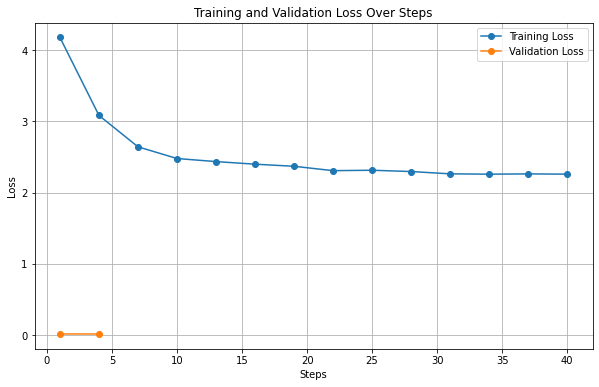

In [ ]:
# Extract logs from the trainer's state
logs = trainer.state.log_history

# Separate training and validation loss
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Generate step indices (multiples of 3)
train_steps = [(i * 3) +1 for i in range( len(train_loss))]
eval_steps = [(i * 3) +1 for i in range( len(eval_loss))]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker="o")
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Steps")
plt.legend()
plt.grid()
plt.show()

## Final Training after Hyperparameter searching

In [ ]:
torch.cuda.empty_cache()

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base" , low_cpu_mem_usage=True)

# Move model to the device
model = model.to(device)

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
training_args = TrainingArguments(
    output_dir="./bart_results2",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate = 0.0001,
    eval_steps=None,
    save_steps=None,
    gradient_accumulation_steps=8,
    logging_dir="./logs2",  
    logging_steps=100,     
    eval_strategy="epoch",  
    save_strategy="epoch",        
    #load_best_model_at_end=True,  
    fp16=True                    
)

model.generation_config.num_beams = 1

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    compute_metrics=compute_rogue_metric,
)

/scratch/19314200/ipykernel_1028235/1320260731.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
results_logs = trainer.train()

Epoch,Training Loss,Validation Loss


  0%|          | 0/352 [00:00<?, ?it/s]/user/shubham/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 352/352 [11:31<00:00,  1.97s/it]


{'eval_loss': 0.006868384778499603, 'step': 175, 'bleu': 0.1251738842480736}


/user/shubham/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
100%|██████████| 352/352 [36:40<00:00,  6.25s/it]


{'eval_loss': 0.006826714358546517, 'step': 350, 'bleu': 0.13662491221214823}


 68%|██████▊   | 239/352 [25:21<11:52,  6.30s/it]

above training got completed till 3 epochs and got good enough results, logs shows incomplete training due to connection error with CCR.
This same model with checkpoint 525 is loaded below for evaluation.

In [ ]:
with open("checkpoint-525/trainer_state.json", "r") as f:
    logs = json.load(f)


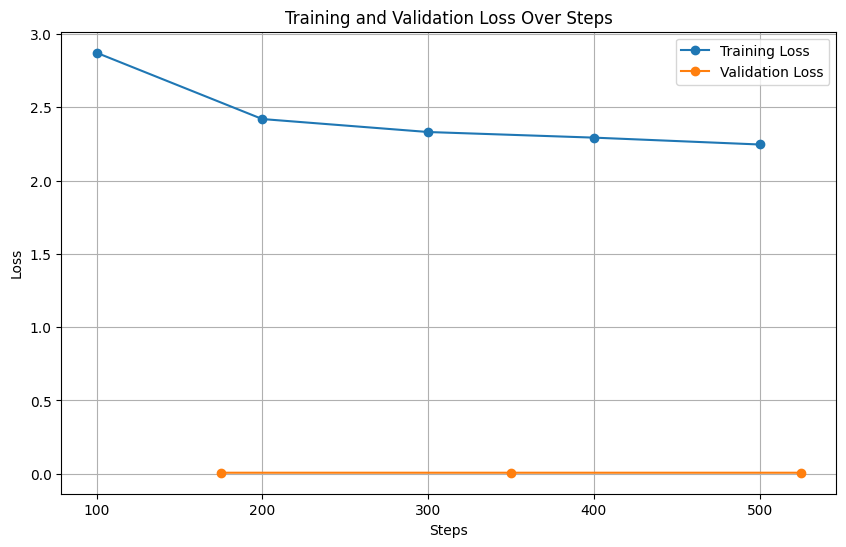

In [ ]:

logs = logs["log_history"]

train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in logs:
    if "loss" in log:  
        train_loss.append(log["loss"])
        train_steps.append(log["step"])  
    if "eval_loss" in log:  
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"]) 
        


# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker="o")
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Steps")
plt.legend()
plt.grid()
plt.show()

3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

In [ ]:
def model_init():
    torch.cuda.empty_cache()
    return BartForConditionalGeneration.from_pretrained("facebook/bart-base" , low_cpu_mem_usage=True)

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate",5e-4 ,0.01 , log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16] ),
        "gradient_accumulation_steps":trial.suggest_int("gradient_accumulation_steps", 2 ,8,2 )
    }

In [ ]:
torch.cuda.empty_cache()
trainer = Trainer(
    model_init=model_init,
    args=TrainingArguments(
        output_dir="./hp_search",
        eval_strategy="epoch",
        num_train_epochs = 10,
        save_strategy="no",
        
    
    ),
    train_dataset=dataset["train"].select(range(1000)),
    eval_dataset=dataset["validation"].select(range(100)),
)

In [ ]:
best_run = trainer.hyperparameter_search(
    direction="minimize",
    compute_objective=lambda metrics: metrics["eval_loss"],
    hp_space=hp_space,
    n_trials=6
)

[I 2025-04-10 14:11:59,801] A new study created in memory with name: no-name-84cfe0b8-7106-4bfb-b75e-3229844c6e9c
/scratch/19319714/ipykernel_2020354/181899475.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "gradient_accumulation_steps":trial.suggest_int("gradient_accumulation_steps", 2 ,8,2 )


Epoch,Training Loss,Validation Loss
1,No log,8.640704
2,No log,8.004749
3,No log,7.641426
4,No log,7.590487
5,No log,7.533312
6,No log,7.534790
7,No log,7.487492
8,No log,7.464221
9,No log,7.453125


[I 2025-04-10 14:18:59,134] Trial 0 finished with value: 7.453125 and parameters: {'learning_rate': 0.0022643296427495426, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 6}. Best is trial 0 with value: 7.453125.


Epoch,Training Loss,Validation Loss
1,No log,7.928050
2,No log,7.586646
3,No log,7.481344
4,No log,7.467069
5,No log,7.462449
6,No log,7.459639
7,No log,7.450562
8,No log,7.427693
9,No log,7.434743


[I 2025-04-10 14:26:32,772] Trial 1 finished with value: 7.4347429275512695 and parameters: {'learning_rate': 0.004672247987355705, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 2}. Best is trial 1 with value: 7.4347429275512695.


Epoch,Training Loss,Validation Loss
1,No log,3.369894
2,No log,2.871206
3,No log,2.825751
4,No log,2.899524
5,No log,3.039437
6,No log,3.163853
7,No log,3.243370
8,No log,3.314226
9,No log,3.377328


[I 2025-04-10 14:34:21,489] Trial 2 finished with value: 3.377328395843506 and parameters: {'learning_rate': 0.0005687818974239268, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4}. Best is trial 2 with value: 3.377328395843506.


Epoch,Training Loss,Validation Loss
1,No log,15.908215
2,No log,11.674643
3,No log,9.061102
4,No log,8.326944
5,No log,7.980012
6,No log,7.886370
7,No log,7.715248
8,No log,7.701504
9,No log,7.678637


[I 2025-04-10 14:41:21,888] Trial 3 finished with value: 7.6786370277404785 and parameters: {'learning_rate': 0.008811549374910715, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 6}. Best is trial 2 with value: 3.377328395843506.


Epoch,Training Loss,Validation Loss
0,No log,18.444069
1,No log,8.310575
2,No log,7.630814
3,No log,7.548298
4,No log,7.479098
5,No log,7.469403
6,No log,7.466535
7,No log,7.453611
8,No log,7.472438
9,No log,7.460233


[I 2025-04-10 14:49:14,711] Trial 4 finished with value: 7.460233211517334 and parameters: {'learning_rate': 0.0026003707741429254, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 6}. Best is trial 2 with value: 3.377328395843506.


Epoch,Training Loss,Validation Loss
1,No log,14.050137
2,No log,9.151158


[I 2025-04-10 14:50:50,657] Trial 5 pruned. 


In [ ]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate",5e-5 ,5e-3 , log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8] ),
        "gradient_accumulation_steps":trial.suggest_int("gradient_accumulation_steps", 2 ,8,2 )
    }

In [ ]:
torch.cuda.empty_cache()
trainer = Trainer(
    model_init=model_init,
    args=TrainingArguments(
        output_dir="./hp_search",
        eval_strategy="epoch",
        num_train_epochs = 10,
        save_strategy="no",
        
    
    ),
    train_dataset=dataset["train"].select(range(1000)),
    eval_dataset=dataset["validation"].select(range(100)),
)

In [ ]:
best_run = trainer.hyperparameter_search(
    direction="minimize",
    compute_objective=lambda metrics: metrics["eval_loss"],
    hp_space=hp_space,
    n_trials=4
)

[I 2025-04-10 14:56:51,735] A new study created in memory with name: no-name-eb758d9c-b333-49bb-948d-a993d0f91545
/scratch/19319714/ipykernel_2020354/243927772.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "gradient_accumulation_steps":trial.suggest_int("gradient_accumulation_steps", 2 ,8,2 )


Epoch,Training Loss,Validation Loss
1,No log,7.386380
2,No log,7.379225
3,No log,7.331084
4,No log,6.844871
5,No log,4.210353
6,No log,3.678020
7,No log,3.634279
8,No log,3.661283
9,No log,3.771301


[I 2025-04-10 15:04:53,278] Trial 0 finished with value: 3.7713005542755127 and parameters: {'learning_rate': 0.0007485225544064737, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 8}. Best is trial 0 with value: 3.7713005542755127.


Epoch,Training Loss,Validation Loss
1,No log,7.361469
2,No log,7.381748
3,No log,7.323060
4,No log,7.349298
5,No log,7.339602
6,No log,7.345047
7,No log,7.344672
8,No log,7.340097
9,No log,7.354069


[I 2025-04-10 15:12:58,223] Trial 1 finished with value: 7.354069232940674 and parameters: {'learning_rate': 0.002725392837594763, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 6}. Best is trial 0 with value: 3.7713005542755127.


Epoch,Training Loss,Validation Loss
1,No log,2.783019
2,No log,2.489359
3,No log,2.434257
4,No log,2.414490
5,No log,2.422788
6,No log,2.427473
7,No log,2.433392
8,No log,2.435237
9,No log,2.440766


[I 2025-04-10 15:20:58,872] Trial 2 finished with value: 2.4407663345336914 and parameters: {'learning_rate': 6.280462806282225e-05, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 8}. Best is trial 2 with value: 2.4407663345336914.


Epoch,Training Loss,Validation Loss
1,No log,2.487877
2,No log,2.496062
3,No log,2.491511
4,2.330500,2.554279
5,2.330500,2.632462
6,2.330500,2.672012
7,2.330500,2.708142
8,1.469200,2.754170
9,1.469200,2.796348
10,1.469200,2.816476


[I 2025-04-10 15:29:41,122] Trial 3 finished with value: 2.8164758682250977 and parameters: {'learning_rate': 0.0001005462821966021, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 2.4407663345336914.


4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).

<span style='color:green'>
1. Training Process: 
   <ul>
   <li>The inputs and summaries truncated or padded to a maximum length of 1024 tokens with Bart Tokenizer</li>
   <li>Mixed precision training (fp16) is used to reduce memory usage and speed up training.</li>
   </ul>
2. Hyperparameters Used: 
   <ul>
   <li>Learning Rate : 0.0001</li>
   <li>Batch Size : 32 </li>
   <li>Number of Epochs : 3</li>
   <li>Weight Decay : 0.01</li>
   <li>Gradient Accumulation : 8</li>
   </ul>
3. Evaluation: 
   <ul>
   <li>Evaluation Steps : Each Epoch</li>
   <li>Batch Size : 16 </li>
   <li>Model is evaluated during training on validation data which is evaluated using Bleu Score and validation score</li>
   </ul>
3. Challenges: 
   <ul>
   <li>Memory Constraints: Maxmium batch size which can fit on 40GB memory is 32 which is a drawback</li>
   <li>Slow training due to heavy computation, without GPU very difficult to train </li>
   </ul>
</span>

## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [ ]:
from rouge_score import rouge_scorer
import sacrebleu
from bert_score import score

In [ ]:
# Load the checkpointed model and tokenizer
checkpoint_path = "./bart_results2/checkpoint-525"  
model = BartForConditionalGeneration.from_pretrained(checkpoint_path)
tokenizer = BartTokenizer.from_pretrained(checkpoint_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextSummaryDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"]),
            "attention_mask": torch.tensor(item["attention_mask"]),
            "summary": item["summary"]  
        }

In [ ]:
def generate_predictions(model, tokenizer, test_loader, max_length=250):
    """
    Generate predictions for the test data.
    """
    model.eval()
    predictions = []
    references = []

    for data in tqdm(test_loader):
        inputs = data["input_ids"].to(device)               
        attention_mask = data["attention_mask"].to(device)  

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=3,
                early_stopping=True
            )

        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        ref = data["summary"][0]  

        predictions.append(pred)
        references.append(ref)

    return predictions, references


In [ ]:
test_dataset = TextSummaryDataset(dataset["test"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
predictions, references = generate_predictions(model, tokenizer, test_loader)

test_results = [{"prediction": pred, "reference": ref} for pred, ref in zip(predictions, references)]


100%|██████████| 176/176 [34:44<00:00, 11.85s/it]


In [ ]:
# Save to a JSON file
output_file = "test_result.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(test_results, f, indent=4, ensure_ascii=False)

In [ ]:

def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = 0, 0, 0

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1 += scores['rouge1'].fmeasure
        rouge2 += scores['rouge2'].fmeasure
        rougeL += scores['rougeL'].fmeasure

    # Average scores
    rouge1 /= len(predictions)
    rouge2 /= len(predictions)
    rougeL /= len(predictions)

    return {"ROUGE-1": rouge1, "ROUGE-2": rouge2, "ROUGE-L": rougeL}


rouge_scores = compute_rouge(predictions, references)
print("ROUGE Scores:", rouge_scores)

ROUGE Scores: {'ROUGE-1': 0.44489676283485796, 'ROUGE-2': 0.16462220649306644, 'ROUGE-L': 0.22897993141524783}


In [ ]:
def compute_bleu(predictions, references):
    references = [[ref] for ref in references]
    bleu = sacrebleu.corpus_bleu(predictions, references)
    return {"BLEU": bleu.score}

bleu_score = compute_bleu(predictions, references)
print("BLEU Score:", bleu_score)

BLEU Score: {'BLEU': 22.69937379775621}


In [ ]:
def compute_bertscore(predictions, references):
    P, R, F1 = score(predictions, references, lang="en", verbose=False)
    return {"BERTScore Precision": P.mean().item(), 
            "BERTScore Recall": R.mean().item(), 
            "BERTScore F1": F1.mean().item()}

bertscore = compute_bertscore(predictions, references)
print("BERTScore:", bertscore)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: {'BERTScore Precision': 0.8674412369728088, 'BERTScore Recall': 0.8577236533164978, 'BERTScore F1': 0.862435519695282}


2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

In [ ]:
with open("checkpoint-525/trainer_state.json", "r") as f:
    logs = json.load(f)
logs = logs["log_history"]

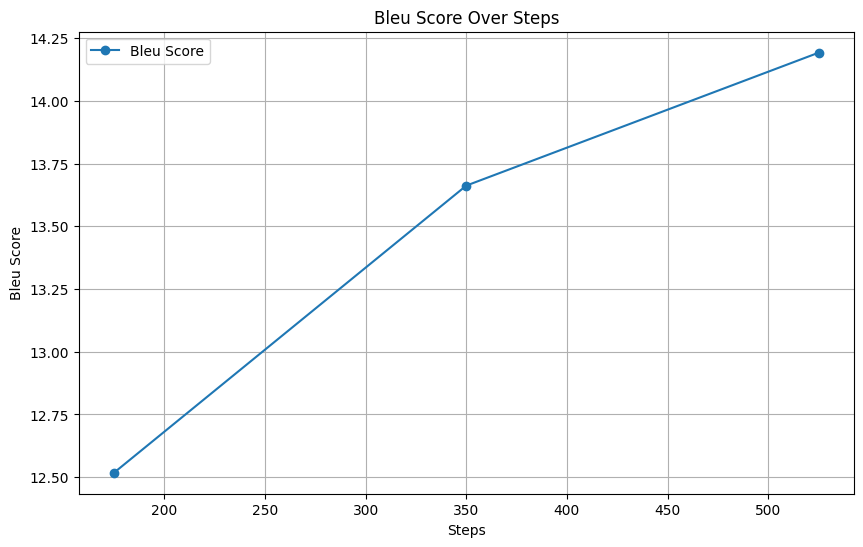

In [ ]:
blue_score = []
steps = []
for log in logs:
    if "bleu" in log:  
        blue_score.append(log["bleu"]*100)
        steps.append(log["step"])  
   


# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, blue_score, label="Bleu Score", marker="o")
plt.xlabel("Steps")
plt.ylabel("Bleu Score")
plt.title("Bleu Score Over Steps")
plt.legend()
plt.grid()
plt.show()

3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).

<span style='color:green'>
1. Model Evaluation is computation expensive as Training because it took very large time to generate the summaries of all test data.</br>
2. Summaries generation with tradeoff between memory consumption and good result. Some parameters during generation like number of beams can effect quality of text generated.</span>

4. Propose potential modifications or extensions to enhance summarization quality.

<span style='color:green'>
we should talk large model which has capability to take more token as input.   
</span>

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

<span style='color:green'>
<ul>
<li>Multinews Datasets : https://huggingface.co/datasets/alexfabbri/multi_news</li>
<li>Tutorial 1 : https://medium.com/@ferlatti.aldo/fine-tuning-a-chat-summarizer-c18625bc817d</li>
<li>Tutorial 2 : https://medium.com/@lidores98/finetuning-huggingface-facebook-bart-model-2c758472e340</li>
</ul>
</span>